In [1]:
import pandas as pd
import numpy as np
import argparse
import random
from model import KGCN
from data_loader import DataLoader
import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# prepare arguments (hyperparameters)
parser = argparse.ArgumentParser()

parser.add_argument('--dataset', type=str, default='music', help='which dataset to use')
parser.add_argument('--aggregator', type=str, default='sum', help='which aggregator to use')
parser.add_argument('--n_epochs', type=int, default=20, help='the number of epochs')
parser.add_argument('--neighbor_sample_size', type=int, default=8, help='the number of neighbors to be sampled')
parser.add_argument('--dim', type=int, default=16, help='dimension of user and entity embeddings')
parser.add_argument('--n_iter', type=int, default=1, help='number of iterations when computing entity representation')
parser.add_argument('--batch_size', type=int, default=32, help='batch size')
parser.add_argument('--l2_weight', type=float, default=1e-4, help='weight of l2 regularization')
parser.add_argument('--lr', type=float, default=5e-4, help='learning rate')
parser.add_argument('--ratio', type=float, default=0.8, help='size of training dataset')

args = parser.parse_args(['--l2_weight', '1e-4'])

# build dataset and knowledge graph
data_loader = DataLoader(args.dataset)
kg = data_loader.load_kg()
df_dataset = data_loader.load_dataset()
df_dataset

# Dataset class
class KGCNDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        user_id = np.array(self.df.iloc[idx]['userID'])
        item_id = np.array(self.df.iloc[idx]['itemID'])
        label = np.array(self.df.iloc[idx]['label'], dtype=np.float32)
        return user_id, item_id, label

# train test split
x_train, x_test, y_train, y_test = train_test_split(df_dataset, df_dataset['label'], test_size=1 - args.ratio, shuffle=False, random_state=999)
train_dataset = KGCNDataset(x_train)
test_dataset = KGCNDataset(x_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size)

# prepare network, loss function, optimizer
num_user, num_entity, num_relation = data_loader.get_num()
user_encoder, entity_encoder, relation_encoder = data_loader.get_encoders()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = KGCN(num_user, num_entity, num_relation, kg, args, device).to(device)
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2_weight)
print('device: ', device)

inIt data        userID  itemID  rating
0           2      51   13883
1           2      52   11690
2           2      53   11351
3           2      54   10300
4           2      55    8983
...       ...     ...     ...
92829    2100   18726     337
92830    2100   18727     297
92831    2100   18728     281
92832    2100   18729     280
92833    2100   18730     263

[92834 rows x 3 columns]
Construct knowledge graph ... Done
Build dataset dataframe ... Done
device:  cuda


In [4]:
# train
from sklearn.metrics import precision_score, recall_score, f1_score
loss_list = []
test_loss_list = []
auc_score_list = []
f1_score_list = []
recall_score_list = []
precision_score_list =[]

for epoch in range(args.n_epochs):
    running_loss = 0.0
    for i, (user_ids, item_ids, labels) in enumerate(train_loader):
        user_ids, item_ids, labels = user_ids.to(device), item_ids.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(user_ids, item_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()
    
    # print train loss per every epoch
    print('[Epoch {}]train_loss: '.format(epoch+1), running_loss / len(train_loader))
    loss_list.append(running_loss / len(train_loader))
        
    # evaluate per every epoch
    with torch.no_grad():
        test_loss = 0
        total_roc = 0
        total_precision =0
        total_recall =0
        total_f1 =0
        for user_ids, item_ids, labels in test_loader:
            user_ids, item_ids, labels = user_ids.to(device), item_ids.to(device), labels.to(device)
            outputs = net(user_ids, item_ids)
            test_loss += criterion(outputs, labels).item()
            total_roc += roc_auc_score(labels.cpu().detach().numpy(), outputs.cpu().detach().numpy())
            
            # 将输出值转换为0或1（阈值为0.5），用于计算Precision、Recall和F1
            preds = (outputs >= 0.5).float()

            # 计算Precision、Recall和F1
            precision = precision_score(labels.cpu().detach().numpy(), preds.cpu().detach().numpy())
            recall = recall_score(labels.cpu().detach().numpy(), preds.cpu().detach().numpy())
            f1 = f1_score(labels.cpu().detach().numpy(), preds.cpu().detach().numpy())
            
            total_precision += precision
            total_recall += recall
            total_f1 += f1
            
        
        print('[Epoch {}]test_loss: '.format(epoch+1), test_loss / len(test_loader))
        print('[Epoch {}]AUC: '.format(epoch+1), total_roc / len(test_loader))
        print('[Epoch {}]test_loss: '.format(epoch+1), total_f1/ len(test_loader))
        test_loss_list.append(test_loss / len(test_loader))
        auc_score_list.append(total_roc / len(test_loader))
        f1_score_list.append(total_f1/ len(test_loader))
        recall_score_list.append(total_recall/ len(test_loader))
        precision_score_list.append(total_precision/ len(test_loader))  

[Epoch 1]train_loss:  0.9094629782414146
[Epoch 1]test_loss:  0.8665132782151622
[Epoch 2]train_loss:  0.8022640141961385
[Epoch 2]test_loss:  0.7983454616479976
[Epoch 3]train_loss:  0.7272880167452752
[Epoch 3]test_loss:  0.7479237071288529
[Epoch 4]train_loss:  0.6756108403608062
[Epoch 4]test_loss:  0.709017579593966
[Epoch 5]train_loss:  0.6379912839083858
[Epoch 5]test_loss:  0.6769940561504775
[Epoch 6]train_loss:  0.6063413016709239
[Epoch 6]test_loss:  0.6482047440223796
[Epoch 7]train_loss:  0.5753257646653978
[Epoch 7]test_loss:  0.620971272389094
[Epoch 8]train_loss:  0.5431061197228116
[Epoch 8]test_loss:  0.5955832820105297
[Epoch 9]train_loss:  0.5103531242543065
[Epoch 9]test_loss:  0.5729664927849205
[Epoch 10]train_loss:  0.47844349240001877
[Epoch 10]test_loss:  0.5536652309920198
[Epoch 11]train_loss:  0.4485097504176913
[Epoch 11]test_loss:  0.5377850346667792
[Epoch 12]train_loss:  0.4213781368273955
[Epoch 12]test_loss:  0.5251589925378881
[Epoch 13]train_loss:  

In [3]:
test_loss_list

[0.8823842320802077,
 0.741704383436239,
 0.7056153499855186,
 0.6989821854627357,
 0.6969358158561418,
 0.6957531112544941,
 0.6948175403307069,
 0.6937730721707615,
 0.6915343066431442,
 0.6833939970664258,
 0.6523830566766127,
 0.5885023082202335,
 0.5357249211590245,
 0.5072070726808512,
 0.49214680374793285,
 0.4841158312446666,
 0.4799605717074196,
 0.47770586182486335,
 0.47638325601253867,
 0.47552290142707104]

In [5]:
auc_score_list

[0.5637009687641132,
 0.5732070433544827,
 0.5925661802985142,
 0.618630152994245,
 0.6500231280953876,
 0.6865810431555156,
 0.7241507740403875,
 0.7524320917980921,
 0.775978671658654,
 0.7944984525972975,
 0.8085348192743088,
 0.8205114628584562,
 0.8304441057798921,
 0.8349674090315877,
 0.8390701378484607,
 0.8417699566264183,
 0.8439875737515032,
 0.8448531566611327,
 0.84510886216414,
 0.8455612521102563]

In [6]:
f1_score_list

[0.5584509298592482,
 0.5658680525524803,
 0.5835945866668321,
 0.6025330446546135,
 0.6163847215864489,
 0.640951668836491,
 0.6693240941162815,
 0.6855624279847574,
 0.6993931164096037,
 0.7119851165628338,
 0.7165679422245521,
 0.7256929752551039,
 0.7324543832841934,
 0.7349004292428687,
 0.7357746432473709,
 0.7383040713692293,
 0.7399730071858427,
 0.7405507629031226,
 0.741074900958669,
 0.7412104230432234]

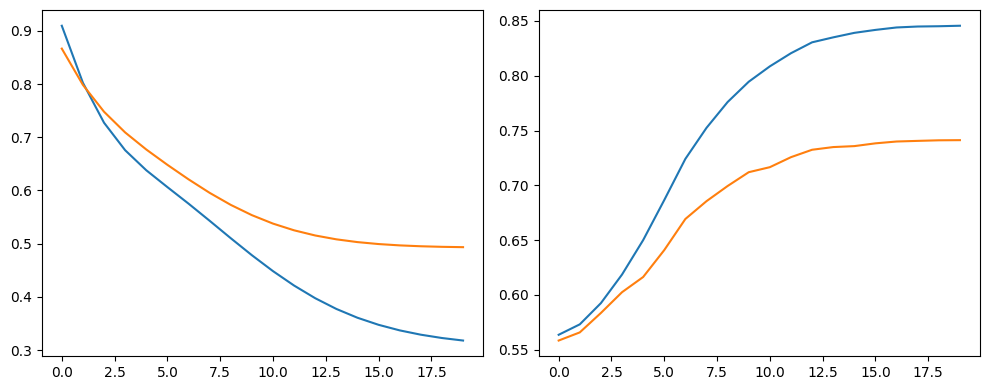

In [7]:
# plot losses / scores
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
ax1.plot(loss_list)
ax1.plot(test_loss_list)
ax2.plot(auc_score_list)
ax2.plot(f1_score_list)

plt.tight_layout()